# Machine learning pipeline

## Load packages

In [1]:
'''
Machine learning HW 2
Spring 2019
pete rodrigue
'''

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pylab
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Set your working directory to the root folder of the repository (ML_spring_2019) on your computer

### You may need to change the path below:

In [2]:
os.chdir("C:\\Users\\edwar.WJM-SONYLAPTOP\\Documents\\GitHub\\ML_spring_2019")

## Define all our functions

In [3]:
def load_and_peek_at_data(path, summary=False):
    '''
    Loads our data and returns a pandas dataframe.
    This function also saves a csv file with descriptive statistics for all
    our variables to our figures folder.
    '''
    separator = '************************\n************************\n\n'
    df = pd.read_csv(path)
    print(separator)
    print('Head of data:')
    print(df.head(5))
    print(separator)
    print('Tail of data:')
    print(df.tail(5))
    print(separator)
    print('column names of data:')
    print(df.columns)
    print(separator)
    print('number of rows of data:')
    print(len(df))
    print(separator)

    if summary:
        print("\n\n\nSummary of data:")
        print(df.describe())
        df.describe().to_csv('exercise two/figures/summary.csv')

    return df


def make_graphs(df, normal_qq_plots=False):
    '''
    Takes our dataframe, fills in missing values with the median,
    and outputs a series of plots:
            - Normal qq plots for each variable
            - Boxplots for each variable
            - Histograms for each variable
        - A correlation plot for all our variables

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    df_temp = df._get_numeric_data()
    fill_missing(df_temp)
    g = sns.heatmap(df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])].corr())
    plt.savefig('exercise two/figures/correlation_plot')
    plt.close()
    for col in df_temp.columns:
        plt.clf()
        mycol = df_temp[col][df_temp[col].notna()]
        print('skew', ' for col ', mycol.name, 'is:', mycol.skew())
        if abs(mycol.skew()) > 10:
            path = "exercise two/figures/" + col + "log_transformed"
            g = sns.distplot(mycol)
            g.set_title(col + " dist, log_transformed")
            g.set(xscale='log')
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + \
                       " normal_qq_plot log trans"
                g = stats.probplot(np.log(df[col]+.0001),
                                   dist="norm", plot=pylab)
                plt.title(col + " normal_qq log transformed")
                plt.savefig(path)
        else:
            path = "exercise two/figures/" + col
            g = sns.distplot(mycol)
            g.set_title(col + " distribution")
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + " normal_qq_plot"
                g = stats.probplot(df[col], dist="norm", plot=pylab)
                plt.title(col + " normal_qq")
                plt.savefig(path)
        plt.clf()
        path = "exercise two/figures/" + col + " boxplot"
        g = sns.boxplot(mycol)
        plt.savefig(path)


def fill_missing(df):
    '''
    Fill missing numerica data in our data frame with the median value of that
    variable. Modifies the dataframe in place. Does not return anything.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    for col in df.columns:
        if df[col].isna().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)


def descretize_var(df, var, num_groups):
    '''
    Takes one of our variables and splits it into discrete groupsself.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make a
                   categorical variable from
        num_groups (int): the number of groups our discrete variable will have

    Returns: a modified dataframe.
    '''
    labs = list(range(1, num_groups + 1))
    labs = [str(x) for x in labs]
    new_var = var + '_discrete'
    df[new_var] = pd.qcut(df[var], num_groups, labels=labs)

    return df


def make_dummies(df, var):
    '''
    Takes our dataframe and turns a specified variable into a series of
    dummy columns. This function returns the modified dataframe.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make dummies of

    Returns: a modified dataframe.
    '''
    new_var_prefix = "D_" + var

    return pd.concat([df, pd.get_dummies(df[var], prefix=new_var_prefix)],
                     axis=1)

## Models

### Tree

In [4]:
def run_tree_model(df, x_data, y_data, max_depth, outcome_labels, threshold):
    '''
    This function takes our data and computes a decision tree model.
    It saves a .dot file you can open in graphviz to see the tree.
    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        max_depth (int): the maximum depth of the tree.
        outcome_labels (list of str): the labels for our predictor variables.
    '''
    model = tree.DecisionTreeClassifier(max_depth=5)
    model.fit(X=x_data, y=y_data)
    
    print("*********Threshold:{0}".format(threshold))
    print('feature names:\n', x_data.columns)
    print('feature importances:\n', model.feature_importances_)
    print('score:\n', model.score(X=x_data, y=y_data))

    tree.export_graphviz(model,
                         out_file='exercise two/figures/tree.dot',
                         feature_names=x_data.columns,
                         class_names=outcome_labels,
                         filled=True)
    
    predicted_probs = pd.DataFrame(model.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
    
    return cm

### Logit model

In [5]:
def run_logit_model(x_data, y_data, threshold=.5):
    '''
    This function takes our x and y data and a threshold,
    and computes a logistic model. It exports a confusion matrix table.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        threshold (float): the threshold, between 0 and 1, that we'll use to
                           to decide if a given row is predicted to be a
                           positive in the target class or not.
    '''
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_data, y_data)

    predicted_probs = pd.DataFrame(logisticRegr.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] > threshold, 'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])

    score = (cm[0][0] + cm[1][1]) / sum(sum(cm))

    plt.clf()
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,
                    square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Using {0} threshold, score is: {1}'.format(
                                                            threshold, score)
    plt.title(all_sample_title, size=15)
    plt.savefig('exercise two/figures/logistic_confusion_matrix')
    plt.clf()
    
    return cm


def logit_try_diff_thresholds(x_data, y_data, step=.05, details=False):
    '''
    This function takes our x and y data and a step,
    and computes a series of logistic models, where the threshold increases
    by the amount given by the step each time.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        step (float): the amount our threshold will increase each time.
    '''
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_data, y_data)
    predicted_probs = pd.DataFrame(logisticRegr.predict_proba(x_data))
    true_pos_correctly_id = []
    true_neg_correctly_id = []
    true_neg_incorrect_id = []

    for threshold in np.arange(0, 1.000001, step):
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data,
                                      predicted_probs['predicted_class'])
        score = (cm[0][0] + cm[1][1]) / sum(sum(cm))
        share_true_negatives = cm[0][0] / sum(cm[0])
        share_true_positives = cm[1][1] / sum(cm[1])
        share_false_negatives = cm[1][0] / sum(cm[1])
        share_false_positives = cm[0][1] / sum(cm[0])
        fpr = cm[0][1] / (sum(cm[0]))
        print("\nThreshold is: ", threshold, '\n',
              'Score is: ', score, '\n')
        if details:
            print('Percent true of negatives correctly identified: ',
                  round(share_true_negatives*100, 2),
                  '\nPercent of true positives erroneously labeled negative: ',
                  round(share_false_negatives*100, 2),
                  '\nPercent of true positives correctly identified: ',
                  round(share_true_positives*100, 2),
                  '\nPercent of true negatives erroneously labeled positive: ',
                  round(share_false_positives*100, 2),
                  '\n')
        print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
        print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
        print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
        true_pos_correctly_id.append(share_true_positives)
        true_neg_correctly_id.append(share_true_negatives)
        true_neg_incorrect_id.append(fpr)

    len_vector = len(np.arange(0, 1.000001, step))
    category = ['true positive']*len_vector
    category = category + ['true negative']*len_vector
    values = true_pos_correctly_id
    values = values + true_neg_correctly_id
    thresholds = list(np.arange(0, 1.000001, step))
    thresholds = thresholds + list(np.arange(0, 1.000001, step))
    to_plot = pd.DataFrame({'values': values,
                            'threshold': thresholds,
                            'category': category})
    plt.clf()
    sns.lineplot(x=thresholds,
                 y=values, hue=category, data=to_plot)
    plt.title("Share of pos and neg correctly id'd, by threshold", size=15)
    plt.savefig('exercise two/figures/logistic_correctly_id_by_threshold')
    plt.clf()
    
    
    print("***********\nAUC is: ", 
          metrics.auc(true_neg_incorrect_id, true_pos_correctly_id), "\n\n")
    random_line = true_neg_incorrect_id[:]
    color = ['True_pos_rate']*len_vector
    color = color + ['Random_model']*len_vector
    x = true_neg_incorrect_id + true_neg_incorrect_id
    y = true_pos_correctly_id + random_line
    to_plot = pd.DataFrame({'False_pos_rate': x,
                            'values': y,
                           'color': color})
    sns.lineplot(x='False_pos_rate',
                 y='values', hue='color', data=to_plot)
    plt.title("ROC curve", size=15)
    plt.savefig('exercise two/figures/logistic_ROC_curve')
    plt.clf()

### K-Nearest Neighbor

In [6]:
def run_knn_model(x_data, y_data, num_n=2, threshold=.5):
    '''
    This function takes our x and y data and a threshold,
    and computes a knn model. It exports a confusion matrix table.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        threshold (float): probability threshold needed to call prediction positive
        num_n (int): the number of neighbors
    '''
    mymodel = KNeighborsClassifier(n_neighbors=num_n)
    mymodel.fit(x_data, y_data)

    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] > threshold, 'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])

    score = (cm[0][0] + cm[1][1]) / sum(sum(cm))

    plt.clf()
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,
                    square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Using {0} threshold and {1} neighbors, score is: {2}'.format(
                                                            threshold, num_n, round(score, 2))
    plt.title(all_sample_title, size=15)
    plt.savefig('exercise two/figures/knn_confusion_matrix')
    plt.clf()
    
    return cm

    
def knn_try_diff_thresholds(x_data, y_data, num_n=2, step=1, details=False):
    '''
    This function takes our x and y data and a step,
    and computes a series of logistic models, where the threshold increases
    by the amount given by the step each time.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        num_n (int): number of neighbors to use
        step (float): the amount our threshold will increase each time.
    '''
    mymodel = KNeighborsClassifier(n_neighbors=num_n)
    mymodel.fit(x_data, y_data)
    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    true_pos_correctly_id = []
    true_neg_correctly_id = []
    true_neg_incorrect_id = []

    for threshold in np.arange(0, 1.000001, step):
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data,
                                      predicted_probs['predicted_class'])
        score = (cm[0][0] + cm[1][1]) / sum(sum(cm))
        share_true_negatives = cm[0][0] / sum(cm[0])
        share_true_positives = cm[1][1] / sum(cm[1])
        share_false_negatives = cm[1][0] / sum(cm[1])
        share_false_positives = cm[0][1] / sum(cm[0])
        fpr = cm[0][1] / (sum(cm[0]))
        print("\nThreshold is: ", threshold, '\n',
              'Score is: ', score, '\n')
        if details:
            print('confusion matrix')
            print('|T neg, F pos|\n|F neg, T pos|')
            print(cm)
            print('Percent true of negatives correctly identified: ',
                  round(share_true_negatives*100, 2),
                  '\nPercent of true positives erroneously labeled negative: ',
                  round(share_false_negatives*100, 2),
                  '\nPercent of true positives correctly identified: ',
                  round(share_true_positives*100, 2),
                  '\nPercent of true negatives erroneously labeled positive: ',
                  round(share_false_positives*100, 2),
                  '\n')
        print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
        print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
        print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
        true_pos_correctly_id.append(share_true_positives)
        true_neg_correctly_id.append(share_true_negatives)
        true_neg_incorrect_id.append(fpr)

    len_vector = len(np.arange(0, 1.000001, step))
    category = ['true positive']*len_vector
    category = category + ['true negative']*len_vector
    values = true_pos_correctly_id
    values = values + true_neg_correctly_id
    thresholds = list(np.arange(0, 1.000001, step))
    thresholds = thresholds + list(np.arange(0, 1.000001, step))
    to_plot = pd.DataFrame({'values': values,
                            'threshold': thresholds,
                            'category': category})
    plt.clf()
    sns.lineplot(x=thresholds,
                 y=values, hue=category, data=to_plot)
    plt.title("Share of pos and neg correctly id'd, by threshold, neighbors = {0}".format(num_n), size=10)
    plt.savefig('exercise two/figures/knn_correctly_id_by_threshold')
    plt.clf()
    
    
    print("***********\nAUC is: ", 
          metrics.auc(true_neg_incorrect_id, true_pos_correctly_id), "\n\n")
    random_line = true_neg_incorrect_id[:]
    color = ['True_pos_rate']*len_vector
    color = color + ['Random_model']*len_vector
    x = true_neg_incorrect_id + true_neg_incorrect_id
    y = true_pos_correctly_id + random_line
    to_plot = pd.DataFrame({'False_pos_rate': x,
                            'values': y,
                           'color': color})
    sns.lineplot(x='False_pos_rate',
                 y='values', hue='color', data=to_plot)
    plt.title("KNN ROC curve, neighbors = {0}".format(num_n), size=10)
    plt.savefig('exercise two/figures/knn_ROC_curve')
    plt.clf()

### SVM

In [7]:
# SVM
def run_svm_model(x_data, y_data, kernel='linear', threshold=.5):
    '''
    Runs and SVM model on your data
    Note: this will run much faster if you scale your x data first
    '''
    mymodel = svm.SVC(kernel='linear', probability=True)
    mymodel.fit(x_data,
                    y_data)  
    mypreds = mymodel.predict(x_data)
    print("*********Threshold:{0}".format(threshold))
    print('confusion matrix')
    print('|T neg, F pos|\n|F neg, T pos|')
    cm = metrics.confusion_matrix(y_data, mypreds)
    print(cm)  
    print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
    print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
    print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
    print(metrics.classification_report(y_data, mypreds))
    
    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
    
    return cm

### Random Forests

In [8]:
# Random Forest
def run_rand_forest(x_data, y_data, my_n_estimators, my_max_depth, threshold=.5):
    '''
    Runs a random forest model
    Inputs:
        x_data (pd dataframe) : our predictor data
        y_data (pd dataframe) : our outcome data
        n_estimators (int): the number of trees in our forest
        max_depth (int): the max number of levels in our trees
    '''
    mymodel = RandomForestClassifier(n_estimators=my_n_estimators, max_depth=my_max_depth)
    mymodel.fit(x_data, y_data)
    
    mypreds = mymodel.predict(x_data)
    print("*********Threshold:{0}".format(threshold))
    print('confusion matrix')
    print('|T neg, F pos|\n|F neg, T pos|')
    cm = metrics.confusion_matrix(y_data, mypreds)
    print(cm)  
    print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
    print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
    print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
    print(metrics.classification_report(y_data, mypreds))
    
    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
    
    return cm

### Boosting

In [9]:
# Boosting
def run_boosted_model(x_data, y_data, my_max_depth, my_n_estimators, threshold):
    '''
    Run a boosted decision tree model
    '''
    mymodel = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=5),
                             algorithm="SAMME",
                             n_estimators=10)
    mymodel.fit(x_data, y_data)
    mypreds = mymodel.predict(x_data)
    print("*********Threshold:{0}".format(threshold))
    print('confusion matrix')
    print('|T neg, F pos|\n|F neg, T pos|')
    cm = metrics.confusion_matrix(y_data, mypreds)
    print(cm)  
    print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
    print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
    print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              round(100 - cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
    print(metrics.classification_report(y_data, mypreds))

    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])

    return cm

### Bagging

In [10]:
# Bagging
def run_bagging_model(x_data, y_data, threshold=.5):
    '''
    Runs a bagging model
    '''
    mymodel = BaggingClassifier(KNeighborsClassifier(),
                                 max_samples=0.5, max_features=0.5)
    mymodel.fit(x_data, y_data)
    mypreds = mymodel.predict(x_data)
    print("*********Threshold:{0}".format(threshold))
    print('confusion matrix')
    print('|T neg, F pos|\n|F neg, T pos|')
    cm = metrics.confusion_matrix(y_data, mypreds)
    print(cm)  
    print('Of all the people we labeled positive, ', 
              round(cm[1][1] / (cm[0][1] + cm[1][1])*100, 2), 
              "% were actually positive, while ",
              round(cm[0][1] / (cm[0][1] + cm[1][1])*100, 2),
              "% were actually negative\n")
    print('We labeled ', cm[1][1] + cm[0][1], ' people as positive.\n')
    print('We labeled ', round(cm[1][1] / sum(cm[1])*100 , 2),
             '% of all the actually positive people positive.\n',
             'Which means we did not label as positive ',
              100 - round(cm[1][1] / sum(cm[1])*100 , 2), 
              '% of all people who are actually positive.\n\n')
    print(metrics.classification_report(y_data, mypreds))
    
    predicted_probs = pd.DataFrame(mymodel.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] >= threshold,
                            'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])
    
    return cm
    

## Load our data

In [11]:
# 1. Read/Load Data
df = load_and_peek_at_data('exercise two/credit-data.csv', summary=True)

************************
************************


Head of data:
   PersonID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0     98976                 0                              1.000000   55   
1     98991                 0                              0.547745   71   
2     99012                 0                              0.044280   51   
3     99023                 0                              0.914249   55   
4     99027                 0                              0.026599   45   

   zipcode  NumberOfTime30-59DaysPastDueNotWorse   DebtRatio  MonthlyIncome  \
0    60601                                     0  505.000000            0.0   
1    60601                                     0    0.459565        15666.0   
2    60601                                     0    0.014520         4200.0   
3    60601                                     4    0.794875         9052.0   
4    60601                                     0    0.049966        10406.0   

  

## Explore data
See "ML_spring_2019\exercise two\figures" for all the figures output by this function.

In [ ]:
# 2. Explore Data
make_graphs(df, normal_qq_plots=False)

## Clean and preprocess data

In [12]:
# 3. Pre-Process and Clean Data
fill_missing(df)
x_data = df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])]
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_data)
x_data_scaled = scaling.transform(x_data)
y_data = df['SeriousDlqin2yrs']

## Generate Features/Predictors

In [ ]:
# 4. Generate Features/Predictors

# one function that can discretize a continuous variable
# df = descretize_var(df, 'MonthlyIncome', 3)

# one function that can take a categorical
# variable and create binary/dummy variables from it.
# make_dummies(df, 'MonthlyIncome_discrete')

## Build and evaluate classifiers

In [97]:
# Logit
run_logit_model(x_data,
                y_data=df['SeriousDlqin2yrs'], threshold=.25)

array([[31009,  3387],
       [ 4079,  2541]], dtype=int64)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Logit with different thresholds
logit_try_diff_thresholds(x_data,
                y_data=df['SeriousDlqin2yrs'], step=.1) 

In [107]:
# KNN
run_knn_model(x_data,
                df['SeriousDlqin2yrs'],
              num_n=8, threshold=.5)

       0      1
0  1.000  0.000
1  0.875  0.125
2  0.875  0.125
3  0.875  0.125
4  1.000  0.000


array([[34265,   131],
       [ 6262,   358]], dtype=int64)

<Figure size 432x288 with 0 Axes>

In [ ]:
# KNN with different thresholds
knn_try_diff_thresholds(x_data,
                df['SeriousDlqin2yrs'],
              num_n=16, step=.1, details=True)

In [102]:
# SVM
run_svm_model(x_data_scaled, df['SeriousDlqin2yrs'], kernel='linear', threshold=.25)

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[34377    19]
 [ 6525    95]]
Of all the people we labeled positive,  83.33 % were actually positive, while  16.67 % were actually negative

We labeled  114  people as positive.

We labeled  1.44 % of all the actually positive people positive.
 Which means we did not label as positive  98.56 % of all people who are actually positive.


             precision    recall  f1-score   support

          0       0.84      1.00      0.91     34396
          1       0.83      0.01      0.03      6620

avg / total       0.84      0.84      0.77     41016



array([[33092,  1304],
       [ 4903,  1717]], dtype=int64)

In [105]:
# Random Forest
run_rand_forest(x_data=x_data, y_data=df['SeriousDlqin2yrs'],
                my_n_estimators=10, my_max_depth=5, threshold=.25)

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[33806   590]
 [ 5341  1279]]
Of all the people we labeled positive,  68.43 % were actually positive, while  31.57 % were actually negative

We labeled  1869  people as positive.

We labeled  19.32 % of all the actually positive people positive.
 Which means we did not label as positive  80.68 % of all people who are actually positive.


             precision    recall  f1-score   support

          0       0.86      0.98      0.92     34396
          1       0.68      0.19      0.30      6620

avg / total       0.83      0.86      0.82     41016



array([[29954,  4442],
       [ 2599,  4021]], dtype=int64)

In [109]:
# Bagging
run_bagging_model(x_data, y_data, threshold=.25)

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[34360    36]
 [ 6229   391]]
Of all the people we labeled positive,  91.57 % were actually positive, while  8.43 % were actually negative

We labeled  427  people as positive.

We labeled  5.91 % of all the actually positive people positive.
 Which means we did not label as positive  94.09 % of all people who are actually positive.


             precision    recall  f1-score   support

          0       0.85      1.00      0.92     34396
          1       0.92      0.06      0.11      6620

avg / total       0.86      0.85      0.79     41016



array([[30925,  3471],
       [ 2047,  4573]], dtype=int64)

In [114]:
# Boosting
run_boosted_model(x_data=x_data, y_data=y_data, my_max_depth=5, my_n_estimators=10, threshold=.5)

confusion matrix
|T neg, F pos|
|F neg, T pos|
[[33085  1311]
 [ 4383  2237]]
Of all the people we labeled positive,  63.05 % were actually positive, while  36.95 % were actually negative

We labeled  3548  people as positive.

We labeled  33.79 % of all the actually positive people positive.
 Which means we did not label as positive  66.21 % of all people who are actually positive.


             precision    recall  f1-score   support

          0       0.88      0.96      0.92     34396
          1       0.63      0.34      0.44      6620

avg / total       0.84      0.86      0.84     41016



array([[32212,  2184],
       [ 4260,  2360]], dtype=int64)




# Loop through models to compare ROCs

In [16]:

def compare_models(x_data, x_data_scaled, y_data,
                   run_bagging=False, run_boosted=False, run_forest=False,
                   run_svm=False, run_knn=False, run_logit=False, run_tree=False,
                   steps=.1,
                   my_max_depth=5, my_n_estimators=10,
                   num_n=8,
                   outcome_labels=None,
                   kernel='linear'):
    '''
    Compare all our models
    '''
    model = []
    fpr = []
    tpr = []
    if run_bagging:
        for t in np.arange(0, 1.000001, steps):
            cm = run_bagging_model(x_data, y_data, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('bagging')
    if run_boosted:
        for t in np.arange(0, 1.000001, steps):
            cm = run_boosted_model(x_data=x_data, y_data=y_data,
                              my_max_depth=my_max_depth, my_n_estimators=my_n_estimators,
                              threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('boosted')
    if run_forest:
        for t in np.arange(0, 1.000001, steps):
            cm = run_rand_forest(x_data=x_data, y_data=y_data,
                        my_n_estimators=my_n_estimators,
                            my_max_depth=my_max_depth, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('forest')
    if run_svm:
        for t in np.arange(0, 1.000001, steps):
            cm = run_svm_model(x_data_scaled, y_data, kernel=kernel, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('svm')
    if run_knn:
        for t in np.arange(0, 1.000001, steps):
            cm = run_knn_model(x_data, y_data, num_n=num_n, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('knn')
    if run_logit:
        for t in np.arange(0, 1.000001, steps):
            cm = run_logit_model(x_data, y_data=y_data, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('logit')
    if run_tree:
        for t in np.arange(0, 1.000001, steps):
            cm = run_tree_model(df,
                       x_data,
                       y_data=y_data,
                       max_depth=my_max_depth,
                       outcome_labels=outcome_labels, threshold=t)
            tpr.append(cm[1][1] / sum(cm[1]))
            fpr.append(cm[0][1] / sum(cm[0]))
            model.append('tree')
            
    to_plot = pd.DataFrame({'model': model, 'tpr': tpr, 'fpr': fpr})
    plt.clf()
    sns.lineplot(x=fpr,
                 y=tpr, hue=model, data=to_plot)
    
    

*********Threshold:0.0
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[34359    37]
 [ 6278   342]]
Of all the people we labeled positive,  90.24 % were actually positive, while  9.76 % were actually negative

We labeled  379  people as positive.

We labeled  5.17 % of all the actually positive people positive.
 Which means we did not label as positive  94.83 % of all people who are actually positive.


             precision    recall  f1-score   support

          0       0.85      1.00      0.92     34396
          1       0.90      0.05      0.10      6620

avg / total       0.85      0.85      0.78     41016

*********Threshold:0.1
confusion matrix
|T neg, F pos|
|F neg, T pos|
[[34347    49]
 [ 6169   451]]
Of all the people we labeled positive,  90.2 % were actually positive, while  9.8 % were actually negative

We labeled  500  people as positive.

We labeled  6.81 % of all the actually positive people positive.
 Which means we did not label as positive  93.19 % of all people 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


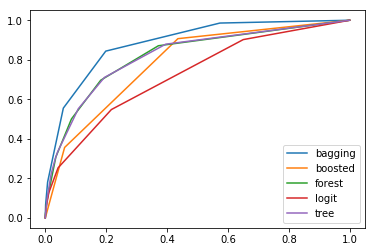

In [17]:
compare_models(x_data, x_data_scaled, y_data,
                   run_bagging=True, run_boosted=True, run_forest=True,
                   run_svm=False, run_knn=False, run_logit=True, run_tree=True,
                   steps=.1,
                   my_max_depth=5, my_n_estimators=10,
                   num_n=8,
                   outcome_labels=None,
                   kernel='linear')